In [1]:
import sys, os
print("Kernel Python:", sys.executable)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

import torch
print("PyTorch:", torch.__version__)

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import pytorch_lightning as pl

from tqdm import tqdm
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print("Current location:", os.getcwd())

# from esm.models.esmc import ESMC
# from esm.sdk.api import ESMProtein, LogitsConfig

Kernel Python: /zhome/c9/0/203261/miniconda3/envs/esm_gpu/bin/python
PyTorch: 2.5.1


/zhome/c9/0/203261/miniconda3/envs/esm_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Current location: /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts


In [2]:
def gaussian_kernel(x, sigma):
    return np.exp(-x**2 / (2 * sigma**2))

def transform_vector(vector, sigma):

    interacting_indices = np.where(vector == 1)[0]   # positions where vector == 1
    transformed_vector = np.zeros_like(vector, dtype=float)
    
    for i in range(len(vector)):
        if vector[i] == 0:
            distances = np.abs(interacting_indices - i)   # distance to all "1"s
            min_distance = np.min(distances)              # closest "1"
            transformed_vector[i] = gaussian_kernel(min_distance, sigma)
        else:
            transformed_vector[i] = 1.0
    return transformed_vector

def safe_shuffle(n, device):
    shuffled = torch.randperm(n, device=device)
    while torch.any(shuffled == torch.arange(n, device=device)):
        shuffled = torch.randperm(n, device=device)
    return shuffled

def create_key_padding_mask(embeddings, padding_value=0, offset=10):
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]):
        non_masked_embeddings = embeddings[i][~padding_mask[i]]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0)
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

class MiniCLIP_w_transformer_crossattn(pl.LightningModule):

    def __init__(self, padding_value = -5000, embed_dimension=1152, num_recycles=1):

        super().__init__()
        self.num_recycles = num_recycles # how many times you iteratively refine embeddings with self- and cross-attention (ALPHA-Fold-style recycling).
        self.padding_value = padding_value
        self.embed_dimension = embed_dimension

        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))  # ~CLIP init

        self.transformerencoder =  nn.TransformerEncoderLayer(
            d_model=self.embed_dimension,
            nhead=8,
            dropout=0.1,
            batch_first=True,
            dim_feedforward=self.embed_dimension
            )
 
        self.norm = nn.LayerNorm(self.embed_dimension)  # For residual additions

        self.cross_attn = nn.MultiheadAttention(
            embed_dim=self.embed_dimension,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )

        self.prot_embedder = nn.Sequential(
            nn.Linear(self.embed_dimension, 640),
            nn.ReLU(),
            nn.Linear(640, 320),
        )
        
    def forward(self, pep_input, prot_input, pep_int_mask=None, prot_int_mask=None, int_prob=None, mem_save=True): # , pep_tokens, prot_tokens

        pep_mask = create_key_padding_mask(embeddings=pep_input,padding_value=self.padding_value)
        prot_mask = create_key_padding_mask(embeddings=prot_input,padding_value=self.padding_value)
 
        # Initialize residual states
        # pep_emb = pep_input.clone()
        # prot_emb = prot_input.clone()

        pep_emb  = pep_input
        prot_emb = prot_input
 
        for _ in range(self.num_recycles):

            # Transformer encoding with residual
            pep_trans = self.transformerencoder(self.norm(pep_emb), src_key_padding_mask=pep_mask)
            prot_trans = self.transformerencoder(self.norm(prot_emb), src_key_padding_mask=prot_mask)

            # Cross-attention with residual
            pep_cross, _ = self.cross_attn(query=self.norm(pep_trans), key=self.norm(prot_trans), value=self.norm(prot_trans), key_padding_mask=prot_mask)
            prot_cross, _ = self.cross_attn(query=self.norm(prot_trans), key=self.norm(pep_trans), value=self.norm(pep_trans), key_padding_mask=pep_mask)
            
            # Additive update with residual connection
            pep_emb = pep_emb + pep_cross  
            prot_emb = prot_emb + prot_cross

        pep_seq_coding = create_mean_of_non_masked(pep_emb, pep_mask)
        prot_seq_coding = create_mean_of_non_masked(prot_emb, prot_mask)
        
        # Use self-attention outputs for embeddings
        pep_seq_coding = F.normalize(self.prot_embedder(pep_seq_coding))
        prot_seq_coding = F.normalize(self.prot_embedder(prot_seq_coding))
 
        if mem_save:
            torch.cuda.empty_cache()
        
        scale = torch.exp(self.logit_scale).clamp(max=100.0)
        logits = scale * (pep_seq_coding * prot_seq_coding).sum(dim=-1) # Dot-Product for comparison
        
        return logits
    

    def training_step(self, batch, device):
        # Passing the sequences to the models
 
        embedding_pep = batch[0]
        embedding_prot = batch[1]
 
        embedding_pep = embedding_pep.to(device)
        embedding_prot = embedding_prot.to(device)

        positive_logits = self(embedding_pep, embedding_prot)
        
        rows, cols = torch.triu_indices(embedding_prot.size(0), embedding_prot.size(0), offset=1)         
        
        negative_logits = self(embedding_pep[rows,:,:], embedding_prot[cols,:,:], int_prob=0.0)

        positive_loss = F.binary_cross_entropy_with_logits(positive_logits, torch.ones_like(positive_logits).to(device))
 
        # loss of predicting peptide using partner
        negative_loss =  F.binary_cross_entropy_with_logits(negative_logits, torch.zeros_like(negative_logits).to(device))
        
        loss = (positive_loss + negative_loss) / 2
 
        torch.cuda.empty_cache()
        return loss
    
    def validation_step(self, batch, device):
        # Predict on random batches of training batch size
        embedding_pep = batch[0]
        embedding_prot = batch[1]
        embedding_pep = embedding_pep.to(device)
        embedding_prot = embedding_prot.to(device)

        with torch.no_grad():

            positive_logits = self(
                    embedding_pep,
                    embedding_prot,
                    # interaction_pep,
                    # interaction_prot,
                    # int_prob = 0.0
                    )
            
            # loss of predicting partner using peptide
            positive_loss = F.binary_cross_entropy_with_logits(positive_logits, torch.ones_like(positive_logits).to(device))
            
            # Negaive indexes
            rows, cols = torch.triu_indices(embedding_prot.size(0), embedding_prot.size(0), offset=1) 
            

            negative_logits = self(embedding_pep[rows,:,:], 
                              embedding_prot[cols,:,:], 
                              int_prob=0.0)
                   
            
            negative_loss =  F.binary_cross_entropy_with_logits(negative_logits, torch.zeros_like(negative_logits).to(device))

            loss = (positive_loss + negative_loss) / 2
           
            logit_matrix = torch.zeros((embedding_pep.size(0),embedding_pep.size(0)),device=self.device)
            logit_matrix[rows, cols] = negative_logits
            logit_matrix[cols, rows] = negative_logits
            
            # Fill diagonal with positive scores
            diag_indices = torch.arange(embedding_pep.size(0), device=self.device)
            logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()

            labels = torch.arange(embedding_prot.size(0)).to(self.device)
            peptide_predictions = logit_matrix.argmax(dim=0)
            peptide_ranks = logit_matrix.argsort(dim=0).diag() + 1
            peptide_mrr = (peptide_ranks).float().pow(-1).mean()
            
            # partner_accuracy = partner_predictions.eq(labels).float().mean()
            peptide_accuracy = peptide_predictions.eq(labels).float().mean()
    
            k = 3
            peptide_topk_accuracy = torch.any((logit_matrix.topk(k, dim=0).indices - labels.reshape(1, -1)) == 0, dim=0).sum() / logit_matrix.shape[0]
            # partner_topk_accuracy = torch.any((logits.topk(k, dim=1).indices - labels.reshape(-1, 1)) == 0, dim=1).sum() / logits.shape[0]
    
            del logit_matrix,positive_logits,negative_logits,embedding_pep,embedding_prot

            return loss, peptide_accuracy, peptide_topk_accuracy

    def calculate_logit_matrix(self,embedding_pep,embedding_prot):
        positive_logits = self(
            embedding_pep,
            embedding_prot)
        
        # Negaive indexes
        rows, cols = torch.triu_indices(embedding_pep.size(0), embedding_pep.size(0), offset=1) 
        
        negative_logits = self(embedding_pep[rows,:,:], 
                      embedding_prot[cols,:,:], 
                      int_prob=0.0)
        
        logit_matrix = torch.zeros((embedding_pep.size(0),embedding_pep.size(0)),device=self.device)
        logit_matrix[rows, cols] = negative_logits
        logit_matrix[cols, rows] = negative_logits
        # Fill diagonal with positive scores
        diag_indices = torch.arange(embedding_pep.size(0), device=self.device)
        logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()
        return logit_matrix

In [3]:
path = '../PPI_PLM/models/CLIP_no_structural_information/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_4/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_epoch_4.pth'
checkpoint = torch.load(path, weights_only=False, map_location=torch.device('cpu'))
# print(list(checkpoint["model_state_dict"]))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MiniCLIP_w_transformer_crossattn()
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()  # or model.train()

MiniCLIP_w_transformer_crossattn(
  (transformerencoder): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=1152, out_features=1152, bias=True)
    )
    (linear1): Linear(in_features=1152, out_features=1152, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=1152, out_features=1152, bias=True)
    (norm1): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (norm): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
  (cross_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=1152, out_features=1152, bias=True)
  )
  (prot_embedder): Sequential(
    (0): Linear(in_features=1152, out_features=640, bias=True)
    (1): ReLU()
    (2): Linear(in_features=640, out_features=32

In [4]:
interaction_df = pd.read_csv("../data/meta_analysis/interaction_df_metaanal.csv", index_col = 0).drop(columns = ["binder_id", "target_id"]).rename(columns={
    "A_seq" : "binder_seq",
    "B_seq" : "target_seq"
})
interaction_df.target_id_mod.unique()

array(['VirB8', 'FGFR2', 'IL7Ra', 'InsulinR', 'EGFR', 'SARS_CoV2_RBD',
       'Pdl1', 'EGFR_2', 'TrkA', 'IL10Ra', 'LTK', 'Mdm2', 'EGFR_3',
       'sntx', 'sntx_2', 'IL2Ra'], dtype=object)

In [5]:
# Targets df
target_df = interaction_df[["target_id_mod","target_seq"]].rename(columns={"target_seq":"sequence", "target_id_mod" : "ID"})
target_df["seq_len"] = target_df["sequence"].apply(len)
target_df = target_df.drop_duplicates(subset=["ID","sequence"])
target_df = target_df.set_index("ID")

# Binders df
binder_df = interaction_df[["target_binder_ID","binder_seq"]].rename(columns={"binder_seq":"sequence", "target_binder_ID" : "ID"})
binder_df["seq_len"] = binder_df["sequence"].apply(len)
binder_df = binder_df.set_index("ID")

# target_df

# Interaction Dict
interaction_Dict = dict(enumerate(zip(interaction_df["target_id_mod"], interaction_df["target_binder_ID"]), start=1))
# interaction_Dict

In [6]:
max_len = int(target_df['sequence'].str.len().max())        # if strings
torch.full((len(target_df), max_len, 1152), -5000, dtype=torch.float32).shape

torch.Size([16, 621, 1152])

In [7]:
target_df.head()

,sequence,seq_len
ID,,
VirB8,ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...,138
FGFR2,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,101
IL7Ra,DYSFSCYSQLEVNGSQHSLTCAFEDPDVNTTNLEFEICGALVEVKC...,193
InsulinR,EVCPGMDIRNNLTRLHELENCSVIEGHLQILLMFKTRPEDFRDLSF...,150
EGFR,RKVCNGIGIGEFKDSLSINATNIKHFKNCTSISGDLHILPVAFRGD...,191


In [8]:
class CLIP_dataset(Dataset):
    def __init__(self, sequence_df, esm_encoding_paths, embedding_dim=1152, padding_value=-5000):
        super(CLIP_dataset, self).__init__()

        self.sigma = 1
        self.sequence_df = sequence_df
        self.max_length = sequence_df["seq_len"].max()
        self.sequence_df["index_num"] = np.arange(len(self.sequence_df))
        self.esm_encoding_paths = esm_encoding_paths
        num_samples = len(self.sequence_df)
        self.x = torch.full((num_samples, self.max_length, embedding_dim), padding_value, dtype=torch.float32)
        
        # Load embeddings into the pre-allocated tensor
        iterator = tqdm(self.sequence_df.index.tolist(), position=0, leave=True, total=num_samples, desc="# Reading in ESM-embeddings from folder")
        for i, accession in enumerate(iterator):
            try:
                embd = np.load(os.path.join(esm_encoding_paths, accession + ".npy"))[0]
                length_to_pad = self.max_length - len(embd)
                if length_to_pad > 0:
                    zero_padding = np.ones((length_to_pad, embd.shape[1])) * padding_value
                    padded_array = np.concatenate((embd, zero_padding), axis=0)
                else:
                    padded_array = embd[:self.max_length] 
                self.x[i] = torch.tensor(padded_array, dtype=torch.float32)
            except FileNotFoundError as e:
                raise FileNotFoundError(f"Embedding file {accession}.npy not found.")
                
    def __len__(self):
        return int(self.x.shape[0])

    def __getitem__(self, index):
        index1 = self.sequence_df.loc[index,"index_num"]
        return self.x[index1]

In [9]:
targets_dataset = CLIP_dataset(target_df, esm_encoding_paths="../data/meta_analysis/targets_embeddings", embedding_dim=1152)
binders_dataset = CLIP_dataset(binder_df, esm_encoding_paths="../data/meta_analysis/binders_embeddings", embedding_dim=1152)

# Reading in ESM-embeddings from folder: 100%|█████████████████████████████████████| 3532/3532 [00:05<00:00, 642.45it/s]


In [10]:
binders_dataset["IL7Ra_4"].shape

torch.Size([250, 1152])

In [11]:
interaction_lst = list(interaction_Dict.values())
interaction_lst[:10]

[('VirB8', 'VirB8_1'),
 ('FGFR2', 'FGFR2_1'),
 ('FGFR2', 'FGFR2_2'),
 ('FGFR2', 'FGFR2_3'),
 ('FGFR2', 'FGFR2_4'),
 ('FGFR2', 'FGFR2_5'),
 ('FGFR2', 'FGFR2_6'),
 ('FGFR2', 'FGFR2_7'),
 ('FGFR2', 'FGFR2_8'),
 ('FGFR2', 'FGFR2_9')]

In [12]:
# Batching function:
def batch_list(iterable, batch_size=1):
    length = len(iterable)
    for start in range(0, length, batch_size):
        end = min(start + batch_size, length)
        yield iterable[start:end]

batch_size = 20
batched_tb = batch_list(interaction_lst, batch_size)

# num_batches = (len(interaction_lst) + batch_size - 1) // batch_size
# print(num_batches)

binders = [i[1] for i in interaction_lst[:20]]
binders_embd = [binders_dataset[i] for i in binders]
binders_embd[0].shape

torch.Size([250, 1152])

In [13]:
# Loading batches
interaction_scores = []

for batch in tqdm(batched_tb, total = round(len(interaction_df)/batch_size),  desc= "#Iterating through batched data"):
    targets_acc = [taget_binder[0] for taget_binder in batch]
    targets_embd = [targets_dataset[i] for i in targets_acc]
    binders_acc = [taget_binder[1] for taget_binder in batch]
    binders_embd = [binders_dataset[i] for i in binders_acc]

    # binders_dataloader = DataLoader(binders_embd, batch_size=batch_size, shuffle=False)
    # targets_dataloader = DataLoader(targets_embd, batch_size=batch_size, shuffle=False)

    binders_batch = torch.stack([binders_dataset[i] for i in binders_acc]).to(device)
    targets_batch = torch.stack([targets_dataset[i] for i in targets_acc]).to(device)
    # binders_batch = next(iter(binders_dataloader)).to(device)
    # targets_batch = next(iter(targets_dataloader)).to(device)
    
    with torch.no_grad():
        logits = model(binders_batch, targets_batch)
        # CLIP_logits represents probailbities of interacting CLIP_logits[i] = prob of mb_batch[i] interacting with hp_index
        interaction_scores.append(logits.unsqueeze(0))
        # print(interaction_scores)

#Iterating through batched data: 100%|████████████████████████████████████████████████| 177/177 [00:17<00:00, 10.14it/s]


In [31]:
# Labels for the predictions
interaction_df

,binder_chain,target_chains,binder,binder_seq,target_seq,target_id_mod,target_binder_ID
0,A,"[""B""]",False,LDFIVFAGPEKAIKFYKEMAKRNLEVKIWIDGDWAVVQVK,ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...,VirB8,VirB8_1
1,A,"[""B""]",False,SEQDETMHRIVRSVIQHAYKHNDEMAEYFAQNAAEIYKEQNKSEEA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1
2,A,"[""B""]",False,DYKQLKKHATKLLELAKKDPSSKRDLLRTAASYANKVLFEDSDPRA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_2
3,A,"[""B""]",False,DEKEELERRANRVAFLAIQIQNEEYHRILAELYVQFMKAAENNDTE...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_3
4,A,"[""B""]",False,PDNKEKLMSIAVQLILRINEAARSEEQWRYANRAAFAAVEASSGSD...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_4
...,...,...,...,...,...,...,...
3527,A,"[""B""]",False,DLRKYAAELVDRLAEKYNLDSDQYNALVRLASELVWQGKSKEEIEK...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_62
3528,A,"[""B""]",False,SKEEIKKEAEELIEELKKKGYNLPLRILEFALKEIEETNSEKYYEQ...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_63
3529,A,"[""B""]",False,SPEYKKFLELIKEAEAARKAGDLDKAKELLEKALELAKKMKAKSLI...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_64
3530,A,"[""B""]",False,DPLLAYKLLKLSQKALEKAYAEDRERAEELLEEAEAALRSLGDEAG...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_65


In [88]:
predicted_interaction_scores = np.concatenate([batch_score.cpu().detach().numpy().reshape(-1,) for batch_score in interaction_scores])
interaction_probabilities = np.concatenate([torch.sigmoid(batch_score[0]).cpu().numpy() for batch_score in interaction_scores])

interaction_df["pred_binder"] = interaction_df["inter_prob"] >= 0.5
interaction_df["intr_scores"] = predicted_interaction_scores
interaction_df["inter_prob"] = interaction_probabilities

interaction_df

,binder_chain,target_chains,binder,binder_seq,target_seq,target_id_mod,target_binder_ID,CLIP_interaction_scores,intr_scores,inter_prob,pred_binder
0,A,"[""B""]",False,LDFIVFAGPEKAIKFYKEMAKRNLEVKIWIDGDWAVVQVK,ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...,VirB8,VirB8_1,6.514344,6.514344,0.998520,True
1,A,"[""B""]",False,SEQDETMHRIVRSVIQHAYKHNDEMAEYFAQNAAEIYKEQNKSEEA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1,-0.901493,-0.901493,0.288744,False
2,A,"[""B""]",False,DYKQLKKHATKLLELAKKDPSSKRDLLRTAASYANKVLFEDSDPRA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_2,-0.259263,-0.259263,0.435545,False
3,A,"[""B""]",False,DEKEELERRANRVAFLAIQIQNEEYHRILAELYVQFMKAAENNDTE...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_3,-0.037938,-0.037938,0.490517,False
4,A,"[""B""]",False,PDNKEKLMSIAVQLILRINEAARSEEQWRYANRAAFAAVEASSGSD...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_4,-0.827777,-0.827777,0.304115,False
...,...,...,...,...,...,...,...,...,...,...,...
3527,A,"[""B""]",False,DLRKYAAELVDRLAEKYNLDSDQYNALVRLASELVWQGKSKEEIEK...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_62,1.431431,1.431431,0.807124,True
3528,A,"[""B""]",False,SKEEIKKEAEELIEELKKKGYNLPLRILEFALKEIEETNSEKYYEQ...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_63,1.312224,1.312224,0.787885,True
3529,A,"[""B""]",False,SPEYKKFLELIKEAEAARKAGDLDKAKELLEKALELAKKMKAKSLI...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_64,0.427289,0.427289,0.605226,True
3530,A,"[""B""]",False,DPLLAYKLLKLSQKALEKAYAEDRERAEELLEEAEAALRSLGDEAG...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_65,2.309150,2.309150,0.909632,True


In [85]:
labels = torch.as_tensor(interaction_df["binder"].to_numpy(copy=False), dtype=torch.float32, device=device)
logits = torch.as_tensor(predicted_interaction_scores, dtype=torch.float32, device=device)

loss = F.binary_cross_entropy_with_logits(logits, labels)
loss

tensor(1.2981, device='cuda:0')

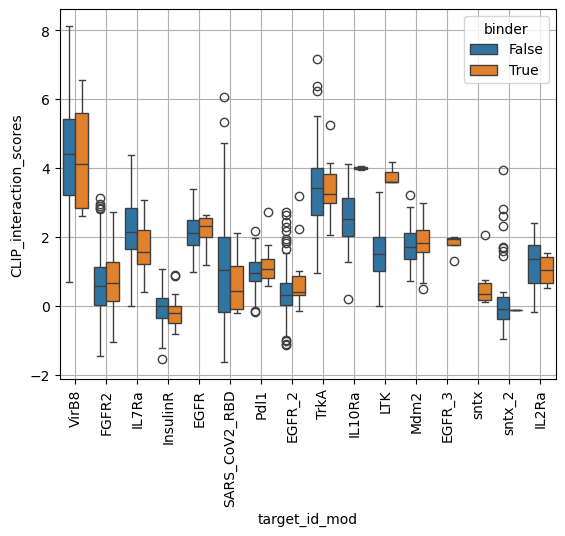

In [81]:
sns.boxplot(data=interaction_df,x="target_id_mod",y="CLIP_interaction_scores",hue="binder",legend=True)
plt.xticks(rotation=90)
plt.grid()
plt.show()

#%%
# import seaborn as sns
# sns.boxplot(data=interaction_df,x="target_id",y="af2_pae_interaction",hue="binder",legend=True)
# plt.xticks(rotation=90)
# plt.grid()
# plt.show()


# import seaborn as sns
# sns.boxplot(data=interaction_df,x="target_id",y="boltz_ipae",hue="binder",legend=True)
# plt.xticks(rotation=90)
# plt.grid()
# plt.show()

In [99]:
pred_binder = interaction_probabilities >= 0.5
true_label = np.array(interaction_df["binder"])

tp = ((pred_binder == 1) & (true_label == 1)).sum().item()
tn = ((pred_binder == 0) & (true_label == 0)).sum().item()
fp = ((pred_binder == 1) & (true_label == 0)).sum().item()
fn = ((pred_binder == 0) & (true_label == 1)).sum().item()

print(f"TP:{tp}, TN:{tn}, FN:{fn}, FP:{fp}")

precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
correct = (true_label == pred_binder).sum()
total   = len(true_label)
accuracy = (correct / total).item()

print({
    "loss": loss.item(),
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
})

TP:330, TN:628, FN:61, FP:2513
{'loss': 0.346200168132782, 'accuracy': 0.27123442808607023, 'precision': 0.1160745691171298, 'recall': 0.8439897698209718, 'f1': 1.0}


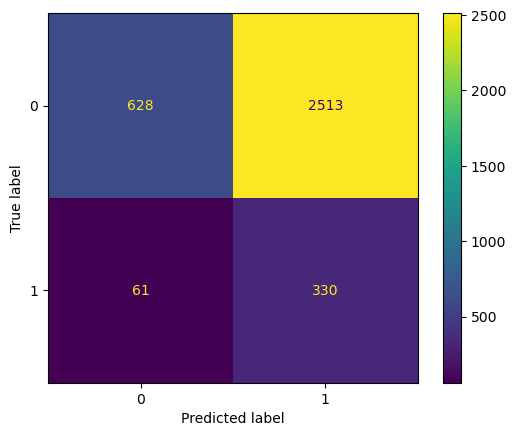

In [101]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_label, pred_binder)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [107]:
for target, subset_df in interaction_df.groupby("target_id_mod"):
    y_true = subset_df["binder"].astype(int).values
    y_scores = subset_df["CLIP_interaction_scores"].values
    # print(target)
    # print(average_precision_score(y_true, y_scores))
    # print((y_true == 1).sum() / len(y_true))
    # print()